<a href="https://colab.research.google.com/github/gilquarshie/Plant-Seedling-Classification/blob/main/Plant_Seedling_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [2]:
# Installing Libraries
# Libraries for Math Operations
import math

# Library for creating data paths
import os

# Library for randomly selecting data points
import random

# Library for performing numerical computations
import numpy as np
import pandas as pd

# Library for creating and showing plots
import matplotlib.pyplot as plt
import seaborn as sns
import cv2                                                                                       # Importing openCV for image processing


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix


# Display images using OpenCV
from google.colab.patches import cv2_imshow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Loading the image file of the dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/Dataset/images.npy')

# Loading the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [5]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 images of shape 128 x 128 X 3, each image having 3 channels.

### Ploting Images

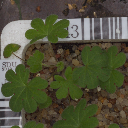

In [6]:
cv2_imshow(images[3])

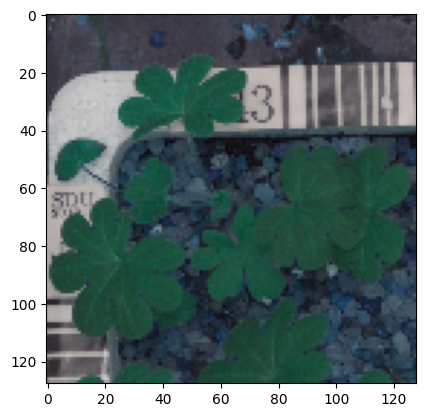

In [7]:
plt.imshow(images[3])

## Exploratory Data Analysis

In [8]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

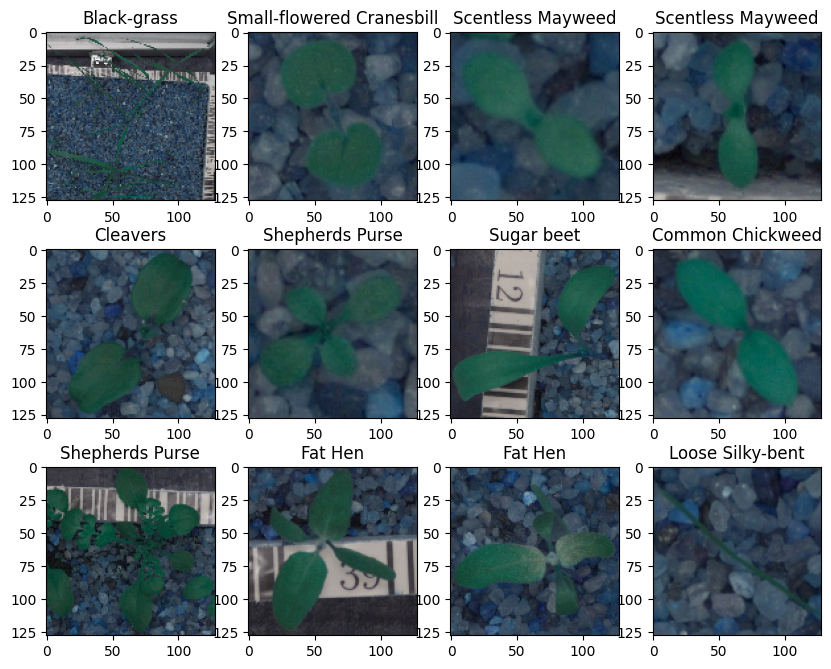

In [9]:
plot_images(images,labels)

### Checking for Data Imbalance

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

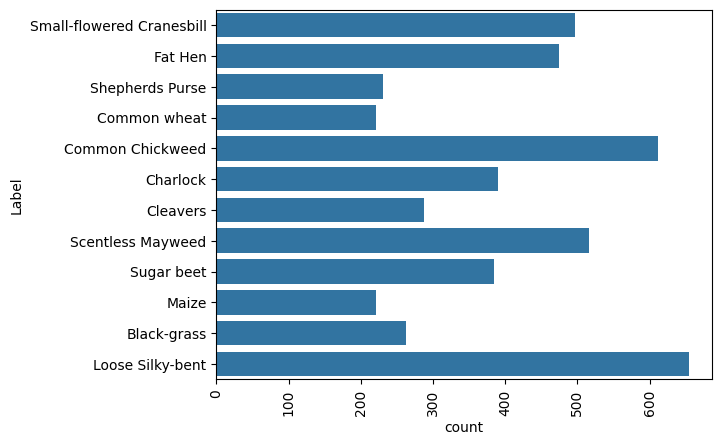

In [10]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

There is data imbalance as images for black-grass, Maize, Shepherds Purse, Common Wheat and others are not enough.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [11]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

In [12]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

### Data Preparation for Modeling

**Splitting the dataset**

In [13]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.15, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.15, random_state=42,stratify=y_temp)

In [14]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3431, 64, 64, 3) (3431, 1)
(606, 64, 64, 3) (606, 1)
(713, 64, 64, 3) (713, 1)


### Treating Data Imbalance

In [15]:
from sklearn.utils import class_weight

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))

### Encode the target labels

In [16]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)
y_test_encoded = enc.transform(y_test)

### Data Normalization

In [17]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [18]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [19]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [20]:
# Intializing a sequential model
model_1 = Sequential()

# Input_shape denotes input image dimension of images
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_1.add(Dense(16, activation='relu'))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model_1.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()
# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

### Fitting the Training Data

In [21]:
history_1 = model_1.fit(
            X_train_normalized, y_train_encoded,
            epochs=60,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=128,
            verbose=2,
            class_weight=class_weights
)

Epoch 1/60
27/27 - 3s - loss: 2.9457 - accuracy: 0.0819 - val_loss: 2.4392 - val_accuracy: 0.1304 - 3s/epoch - 127ms/step
Epoch 2/60
27/27 - 2s - loss: 2.7990 - accuracy: 0.2107 - val_loss: 2.3469 - val_accuracy: 0.2459 - 2s/epoch - 80ms/step
Epoch 3/60
27/27 - 2s - loss: 2.5833 - accuracy: 0.2944 - val_loss: 2.2242 - val_accuracy: 0.3020 - 2s/epoch - 84ms/step
Epoch 4/60
27/27 - 2s - loss: 2.3076 - accuracy: 0.3361 - val_loss: 2.0202 - val_accuracy: 0.3350 - 2s/epoch - 71ms/step
Epoch 5/60
27/27 - 2s - loss: 2.0513 - accuracy: 0.3471 - val_loss: 1.8770 - val_accuracy: 0.3465 - 2s/epoch - 75ms/step
Epoch 6/60
27/27 - 2s - loss: 1.9080 - accuracy: 0.3763 - val_loss: 1.7874 - val_accuracy: 0.3630 - 2s/epoch - 68ms/step
Epoch 7/60
27/27 - 2s - loss: 1.8023 - accuracy: 0.4002 - val_loss: 1.8232 - val_accuracy: 0.3795 - 2s/epoch - 63ms/step
Epoch 8/60
27/27 - 2s - loss: 1.7268 - accuracy: 0.4174 - val_loss: 1.6537 - val_accuracy: 0.4076 - 2s/epoch - 63ms/step
Epoch 9/60
27/27 - 2s - loss: 1

### Model Evaluation

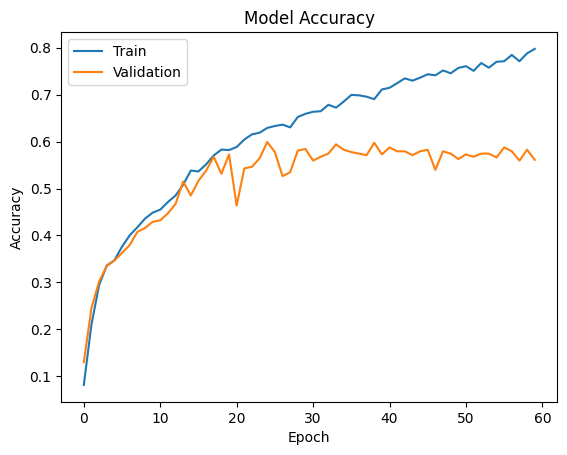

In [22]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model is not generalizing well on the validation data set.

## Model Performance Improvement

### ReduceLRonPlateau

In [23]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [24]:
# Intializing a sequential model
model_2 = Sequential()

model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2), padding = 'same'))


model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2), padding = 'same'))


model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Flatten())


model_2.add(Dense(16, activation='relu'))
model_2.add(Dropout(0.2))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model_2.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()

# Compile model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                        

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate reduction callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by half
    patience=5,          # Wait for 5 epochs before reducing
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print when learning rate is reduced
)

In [26]:
history_2 = model_2.fit(X_train_normalized, y_train_encoded,
            epochs=60,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=128,
            verbose=2,
            class_weight=class_weights,
                     callbacks=[lr_scheduler])

Epoch 1/60
27/27 - 4s - loss: 2.9039 - accuracy: 0.1973 - val_loss: 2.4967 - val_accuracy: 0.0710 - lr: 0.0010 - 4s/epoch - 151ms/step
Epoch 2/60
27/27 - 2s - loss: 2.2431 - accuracy: 0.3098 - val_loss: 2.5041 - val_accuracy: 0.1436 - lr: 0.0010 - 2s/epoch - 75ms/step
Epoch 3/60
27/27 - 2s - loss: 1.8755 - accuracy: 0.4130 - val_loss: 2.5624 - val_accuracy: 0.1370 - lr: 0.0010 - 2s/epoch - 84ms/step
Epoch 4/60
27/27 - 2s - loss: 1.6308 - accuracy: 0.4859 - val_loss: 2.6795 - val_accuracy: 0.1370 - lr: 0.0010 - 2s/epoch - 87ms/step
Epoch 5/60
27/27 - 2s - loss: 1.4267 - accuracy: 0.5377 - val_loss: 2.9579 - val_accuracy: 0.1370 - lr: 0.0010 - 2s/epoch - 76ms/step
Epoch 6/60

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
27/27 - 3s - loss: 1.2509 - accuracy: 0.5879 - val_loss: 3.0617 - val_accuracy: 0.1370 - lr: 0.0010 - 3s/epoch - 93ms/step
Epoch 7/60
27/27 - 3s - loss: 1.1113 - accuracy: 0.6234 - val_loss: 3.2444 - val_accuracy: 0.1370 - lr: 5.0000e-04 - 3

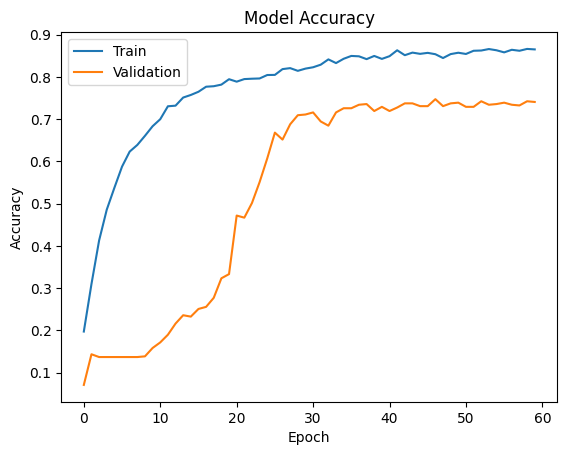

In [27]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This is a significant improvement from the first model. However there is still room for improvement.

### **Data Augmentation**

In [28]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [29]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

In [30]:
# Intializing a sequential model
model_3 = Sequential()

model_3.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

model_3.add(MaxPooling2D((2, 2), padding = 'same'))

model_3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2), padding = 'same'))


model_3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2), padding = 'same'))

model_3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2), padding = 'same'))

model_3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2), padding = 'same'))

model_3.add(Flatten())

model_3.add(Dense(16, activation='relu'))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model_3.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()

# Compile model
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                        

In [31]:
# Epochs
epochs = 80
# Batch size
batch_size =32

history_3 = model_3.fit(train_datagen.flow(X_train_normalized, y_train_encoded, batch_size=batch_size, shuffle=False),
                        epochs=epochs,
                        validation_data=(X_val_normalized,y_val_encoded),
                        verbose=1,
                        class_weight=class_weights,
                        callbacks=[lr_scheduler])

Epoch 1/80
108/108 [==============================] - 8s 54ms/step - loss: 2.4838 - accuracy: 0.2673 - val_loss: 2.7375 - val_accuracy: 0.1650 - lr: 0.0010
Epoch 2/80
108/108 [==============================] - 6s 52ms/step - loss: 1.7460 - accuracy: 0.4369 - val_loss: 3.8269 - val_accuracy: 0.1040 - lr: 0.0010
Epoch 3/80
108/108 [==============================] - 6s 51ms/step - loss: 1.5178 - accuracy: 0.5004 - val_loss: 3.8684 - val_accuracy: 0.1056 - lr: 0.0010
Epoch 4/80
108/108 [==============================] - 6s 52ms/step - loss: 1.2724 - accuracy: 0.5727 - val_loss: 2.5993 - val_accuracy: 0.1551 - lr: 0.0010
Epoch 5/80
108/108 [==============================] - 6s 51ms/step - loss: 1.1799 - accuracy: 0.6065 - val_loss: 1.4351 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 6/80
108/108 [==============================] - 6s 51ms/step - loss: 1.0884 - accuracy: 0.6412 - val_loss: 1.4305 - val_accuracy: 0.5380 - lr: 0.0010
Epoch 7/80
108/108 [==============================] - 6s 52ms/st

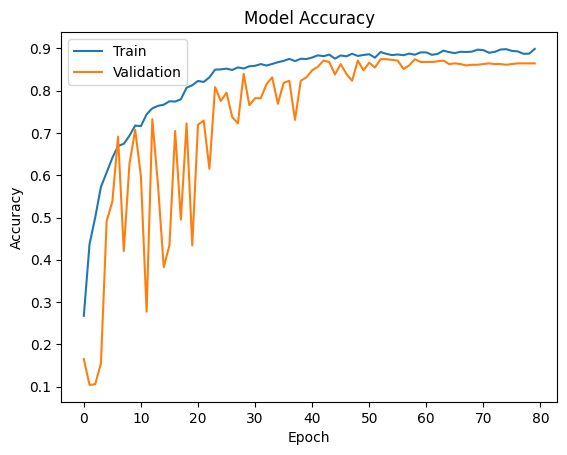

In [32]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Combining Reduced LRon Plateau and Data Augmentation gave phenominal results.

## Final Model

In [33]:
# Extract accuracy values
history_list = [history_1, history_2, history_3]
model_names = ["Base Model", "Reduce LRonPlateau Model", "Data Augmentation"]

# Create a dictionary to store results
results = {
    "Model": [],
    "Train Accuracy": [],
    "Validation Accuracy": []
}

for i, history in enumerate(history_list):
    train_acc = max(history.history["accuracy"])  # Best training accuracy
    val_acc = max(history.history["val_accuracy"])  # Best validation accuracy

    results["Model"].append(model_names[i])
    results["Train Accuracy"].append(round(train_acc, 4))
    results["Validation Accuracy"].append(round(val_acc, 4))

# Convert to DataFrame and display
df_results = pd.DataFrame(results)
print(df_results)

                      Model  Train Accuracy  Validation Accuracy
0                Base Model          0.7971               0.5990
1  Reduce LRonPlateau Model          0.8665               0.7475
2         Data Augmentation          0.8989               0.8746


Data Augmentation model is by far the best model so far.

In [34]:
# Fitting Model on Test Data
test_eval = model_3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

23/23 - 0s - loss: 0.4598 - accuracy: 0.8443 - 207ms/epoch - 9ms/step


In [35]:
#Here we would get the output as probablities for each category
y_pred=model_3.predict(X_test_normalized)

23/23 [==============================] - 0s 8ms/step


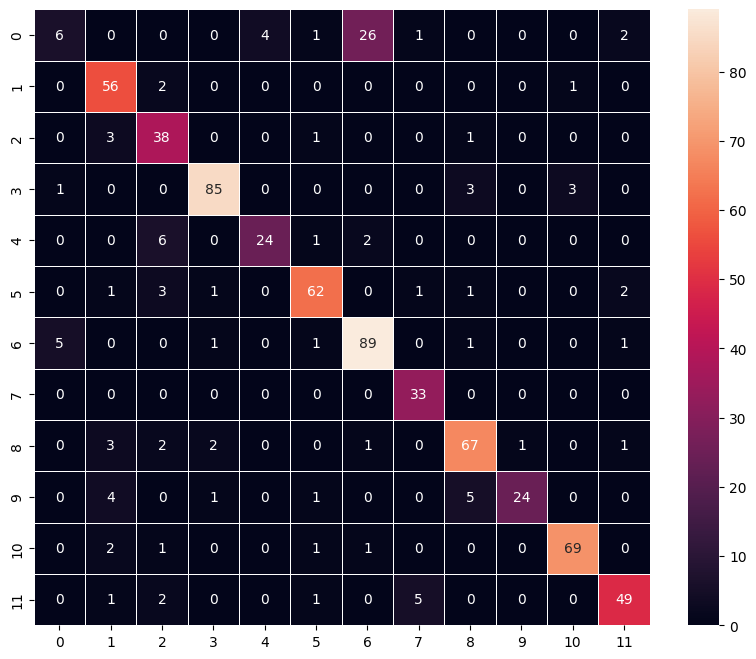

In [36]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

The general performance is good. The only issue is that label 0 keeps being misrepresented as label 6.

### Visualizing the prediction

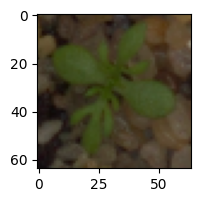

1/1 [==============================] - 0s 25ms/step
Predicted Label ['Scentless Mayweed']
True Label Scentless Mayweed


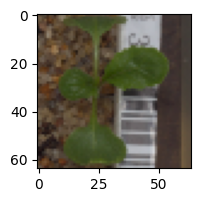

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Charlock']
True Label Charlock


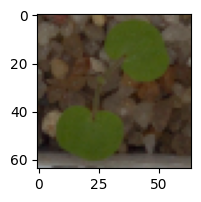

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


In [37]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Actionable Insights and Business Recommendations

* The model keeps misrepresenting Black grass as Loose Silky-bent.

* A partnership can be made with companies in the sector purposely for for obtaining a huge amount of model for the model to be trained well for better accuracy.

_____